# World Bank Real XR

### week 3-2

In this note, we learn how to import World Bank real exchange data, preprocess it, and use it for exchange rate forecasting. Some topics discussed here include:

* Brief review of importing excel exchange rate data
  - some required preprocessing for KRW/USD data to factor in fundamental changes of the monetary regime
* Importing real exchange rate data from World Bank, our first exogeneous variable
* Forecasting exchange rate using current exchange rate and an exogenous variable, real exchange rate.
* Limitations of the forecast and suggestion for improvements.


> *Note 1. source codes: KAIST Business school, Prof. Jaehoon Lee*\
> *Note 2. The concpets covered here (e.g., real XR, market XR, absolute PPP) are from second to third year undergraduate finance course, so concepts themselves are not explained in details here.*

### Review: import and preprocess exchange rate data

In [1]:
import pandas as pd

In [2]:
#import data file - provided in the "data" folder
df_xr = pd.read_excel('data/krw_usd_xr.xlsx')

> When you import time-series data file, two important preprocessing need to be done.

    1. timestamp
    2. date-indexing

In [3]:
#timestamp - already done (check out with df_xr.info())
#df_xr['date'] = pd.to_datetime(df_xr['date'])

In [4]:
#date-indexing
df_xr = df_xr.set_index('date')

> Too many data points can be misleading in that it has risk of making the model's explanatory power seemingly high when it actually is not high. So, we better turn this daily data into monthly data.

> When using "resample" for the purpose, use last of the month data instead of monthly mean to ensure timeliness of data.

In [5]:
#end-of-month observation
df_monthly = df_xr.resample('ME').last()

> You have to consider fundamental changes in monetary regime of the target country as well. Because exchange rates in the long past when there was a different regime (e.g., fixed rate regime) are fundamentally different from exchange rates these days and cannot be used for forecasting. So, in oure context, all exchange rates data before 1998 is discarded.

In [6]:
#because until 1983, it was fixed rate regime
#becuase until 1998, it was deliberately controlled by the regulatory body
df_monthly = df_monthly.loc['1998-12-31' : ]

In [7]:
#to take a breif look at our imported and preprocessed data
import matplotlib.pyplot as plt

In [8]:
df_monthly.columns = ['KRW/USD']

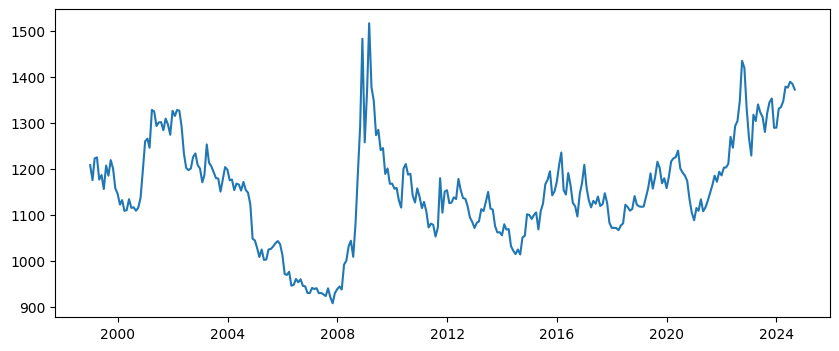

In [9]:
plt.rcParams['figure.figsize'] = (10, 4)
plt.plot(df_monthly['KRW/USD'])
plt.show()

### Download Real XR Data from World Bank

Click the following link and download real exchange rate data from World Bank database:

* [World Bank Real Exchange Rate Data](https://data.worldbank.org/indicator/PA.NUS.PPPC.RF?locations=KR)

Change the name of the file to this: ***world_real_xr.xls***

Remember, real exchange rate is the ratio of internal purchasing power to external purchasing power. In other words, this is also, the ratio of PPP exchange rate to actual market exchange rate. 

In [10]:
#pip install xlrd
df_real_xr = pd.read_excel(
    'data/world_real_xr.xls',
    sheet_name='Data', #among the excel sheets, use 'Data' sheet
    skiprows=3,        #first three rows are irrelavant
)

In [11]:
df_real_xr.head(3)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,Price level ratio of PPP conversion factor (GD...,PA.NUS.PPPC.RF,NaN,NaN,NaN,NaN,NaN,NaN,...,0.732805,0.763304,0.759785,0.757898,0.765701,0.795090,0.788776,0.761985,0.736158,NaN
1,Africa Eastern and Southern,AFE,Price level ratio of PPP conversion factor (GD...,PA.NUS.PPPC.RF,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,Price level ratio of PPP conversion factor (GD...,PA.NUS.PPPC.RF,NaN,NaN,NaN,NaN,NaN,NaN,...,0.280988,0.247614,0.235897,0.224964,0.202007,0.192222,0.199372,0.166339,0.168478,NaN


Among the data sets, we only require korean one.

- Set Country Code as index
- Find 'KOR'

In [12]:
#set Country Code as index
df_real_xr = df_real_xr.set_index('Country Code')

In [13]:
#use Korean data only
df_real_xr = df_real_xr.loc['KOR'].to_frame()

In [14]:
df_real_xr

,KOR
Country Name,"Korea, Rep."
Indicator Name,Price level ratio of PPP conversion factor (GD...
Indicator Code,PA.NUS.PPPC.RF
1960,NaN
1961,NaN
...,...
2019,0.727286
2020,0.702688
2021,0.723172
2022,0.627537


In [15]:
#skip the first three rows
df_real_xr = df_real_xr.iloc[3:]

In [16]:
#drop Nulls
df_real_xr = df_real_xr.dropna()

In [17]:
#additional safety measures: in case older versions of pandas might take the numbers as str type
df_real_xr['KOR'] = df_real_xr['KOR'].astype(float)

In [18]:
from pandas.tseries.offsets import YearEnd, MonthEnd

In [19]:
#timestamp
df_real_xr['date'] = \
    pd.to_datetime(df_real_xr.index) + YearEnd()

In [20]:
#date-indexing
df_real_xr = df_real_xr.set_index('date')

In [21]:
#rename column
df_real_xr.columns = ['Real XR']

In [22]:
df_real_xr.head(3)

,Real XR
date,
1990-12-31,0.791111
1991-12-31,0.806041
1992-12-31,0.797916


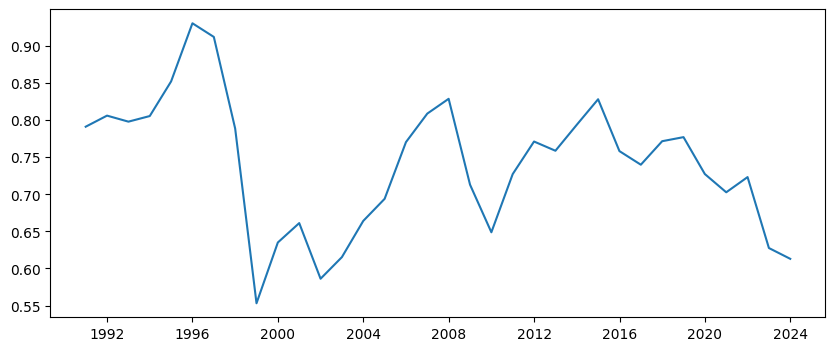

In [23]:
#to take a breif look at our imported and preprocessed data
plt.plot(df_real_xr)
plt.show()

Recall: low real XR means undervalued KRW in relation to USD

> Note 1. Sudden drop in the late 90s: IMF incident and Asian Currency Crisis\
> Note 2. Sudden drop in 2008 to 2009: 2008 Global Financial Crisis

This time, we forecast future exchange rate not only with previous periods exchange rate but also real exchagne rate.

### XR Forecase with Real XR

This time, we will form a forecasting model using not only exchange rates but alos an exogenous variable we downloaded from World Bank.

In [24]:
#pandas join function automatically sets index(dates) as primary key 
df_merged = df_monthly.join(df_real_xr)

In [25]:
df_merged.head(15)

,KRW/USD,Real XR
date,,
1998-12-31,1207.8,0.553049
1999-01-31,1175.3,NaN
1999-02-28,1222.4,NaN
1999-03-31,1224.7,NaN
1999-04-30,1176.4,NaN
1999-05-31,1186.3,NaN
1999-06-30,1155.9,NaN
1999-07-31,1206.9,NaN
1999-08-31,1184.9,NaN


> Exchange rate (downloaded from Bank of Korea) data is monthly\
> Real exchange rate (downloaded from World Bank) data is yearly

There are two ways to deal with NaNs caused by the discrepency of frequency of the two data sets.

1. drop all NaN values: this will make our data sets to be so small that it will make our model's explantory power unjustifiably low.
2. Fill all NaN values: this would be a better methods as it will allow us to maintain the size of data set. Yet, there are a few caveats regarding different ways to fill NaN. 

#### **Method 1. Drop all NaNs**

In [26]:
df_dec = df_merged.dropna()

In [27]:
#error
#because df_dec is mere reference of df_merged (shallow copy)
#for deep copy, follow the following procedures

df_dec['ret'] = df_dec['KRW/USD'].pct_change()*100

C:\Users\jhkan\AppData\Local\Temp\ipykernel_19048\2647952895.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dec['ret'] = df_dec['KRW/USD'].pct_change()*100


In [28]:
#for deepcopy
df_dec = df_dec.copy()

In [29]:
#no error
df_dec['ret'] = df_dec['KRW/USD'].pct_change()*100

In [30]:
df_dec.head()

,KRW/USD,Real XR,ret
date,,,
1998-12-31,1207.8,0.553049,NaN
1999-12-31,1145.4,0.634995,-5.166418
2000-12-31,1259.7,0.661154,9.979047
2001-12-31,1326.1,0.586137,5.271096
2002-12-31,1200.4,0.615282,-9.478923


In [31]:
df_dec.describe()

,KRW/USD,Real XR,ret
count,26.000000,26.000000,25.000000
mean,1144.719231,0.711433,0.655977
std,100.642476,0.076452,9.452311
min,929.600000,0.553049,-12.856904
25%,1075.550000,0.651858,-6.028675
50%,1155.550000,0.725192,0.925129
75%,1205.950000,0.770929,4.358783
max,1326.100000,0.828711,34.033255


Due to the exchange rates' nature of reversion to mean, we expect periods of low real exchange rates would be followed by appreciation of KRW (= lower exchange rates) and vice versa, leading to positive correlation between real exchange rate and percentage change in exchange rate. 

Let's check this with a scatter plot.

#### scatter plot

<Axes: xlabel='Real XR', ylabel='ret'>

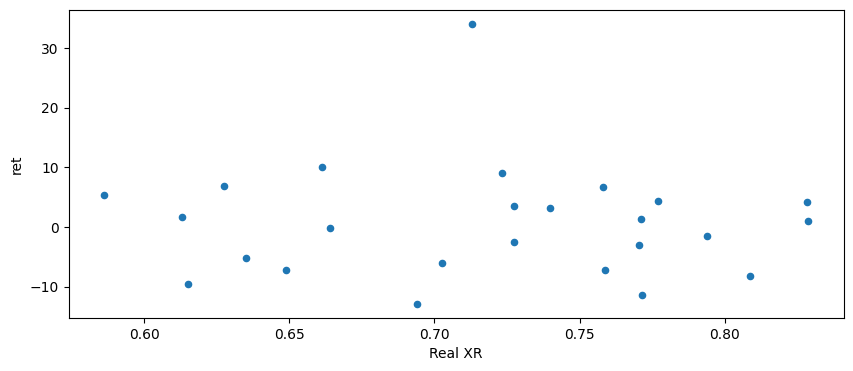

In [32]:
df_dec.plot(kind = 'scatter', x = 'Real XR', y = 'ret')

No such positive relationship is observed! Why??

Becuase we matched the real exchange rate with the **"wrong"** percentage change in exchange rate.

Real XR in the current period should be matched with the expected percentage change in exchange rate of the current period. However, when you take a good look at the data set, as of now current real XR is matched with the expected percentage change in exchange rate of the **previous** period. 

In [33]:
# F means forward, L means lagged
df_dec['F.ret'] = df_dec['ret'].shift(-1)

In [34]:
df_dec.head()

,KRW/USD,Real XR,ret,F.ret
date,,,,
1998-12-31,1207.8,0.553049,NaN,-5.166418
1999-12-31,1145.4,0.634995,-5.166418,9.979047
2000-12-31,1259.7,0.661154,9.979047,5.271096
2001-12-31,1326.1,0.586137,5.271096,-9.478923
2002-12-31,1200.4,0.615282,-9.478923,-0.216594


<Axes: xlabel='Real XR', ylabel='F.ret'>

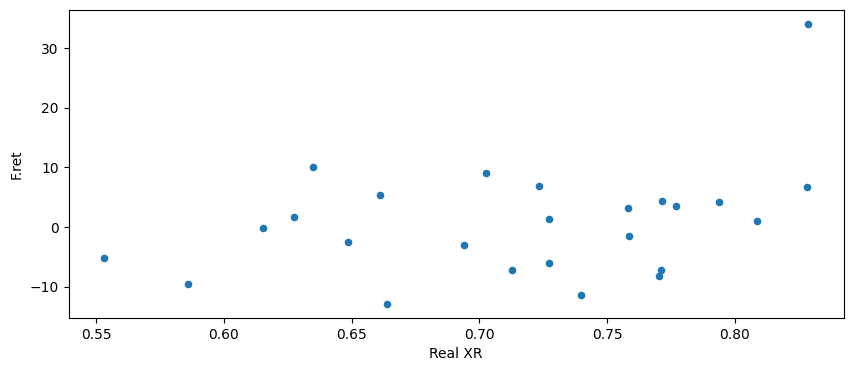

In [35]:
df_dec.plot(kind = 'scatter', x = 'Real XR', y = 'F.ret')

Now, feeble but still positive relationship can be observed.

### OLS

- I mentioned earlier that the weakness of method 1. - dropping all NaNs and make it yearly data has its weakness of weakening the explanatory power of the model. We look into that problem here.

In [36]:
import statsmodels.api as sm

In [37]:
df_dec.head()

,KRW/USD,Real XR,ret,F.ret
date,,,,
1998-12-31,1207.8,0.553049,NaN,-5.166418
1999-12-31,1145.4,0.634995,-5.166418,9.979047
2000-12-31,1259.7,0.661154,9.979047,5.271096
2001-12-31,1326.1,0.586137,5.271096,-9.478923
2002-12-31,1200.4,0.615282,-9.478923,-0.216594


In [38]:
df_dec.tail()

,KRW/USD,Real XR,ret,F.ret
date,,,,
2019-12-31,1157.8,0.727286,3.550666,-6.028675
2020-12-31,1088.0,0.702688,-6.028675,8.961397
2021-12-31,1185.5,0.723172,8.961397,6.900042
2022-12-31,1267.3,0.627537,6.900042,1.743865
2023-12-31,1289.4,0.612982,1.743865,NaN


In [39]:
df = df_dec.dropna()

In [40]:
X = df[['Real XR', 'ret']]
X = sm.add_constant(X)

In [41]:
Y = df['F.ret']

In [42]:
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  F.ret   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     1.454
Date:                Thu, 08 Aug 2024   Prob (F-statistic):              0.256
Time:                        17:56:02   Log-Likelihood:                -86.209
No. Observations:                  24   AIC:                             178.4
Df Residuals:                      21   BIC:                             182.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -32.4671     20.683     -1.570      0.131     -75.480      10.545
Real XR       46.2859     28.513      1.623      0.119     -13.009     105.581
ret           -0.0965      0.203     -0.476      0.639      -0.519       0.326
==============================================================================
Omnibus:                       11.618   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               10.582
Skew:                           1.181   Prob(JB):                      0.00504
Kurtosis:                       5.238   Cond. No.                         174.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> The impact of added exogenous variable is impressive. R-squared jumped from 0.3% to 12% by adding real XR data.\
> However, when you look at the p-values, the coefficients are not significant.\
> This is mainly due to too few data points.

#### **Method 2. Overlapping monthly forecasts with forward fill**

In [43]:
df_merged.head(15)

,KRW/USD,Real XR
date,,
1998-12-31,1207.8,0.553049
1999-01-31,1175.3,NaN
1999-02-28,1222.4,NaN
1999-03-31,1224.7,NaN
1999-04-30,1176.4,NaN
1999-05-31,1186.3,NaN
1999-06-30,1155.9,NaN
1999-07-31,1206.9,NaN
1999-08-31,1184.9,NaN


> This time, instead of dropping NaNs and leaving yearend data points only, we fill the NaNs.\
> There are several ways of subsituting values for NaNs:

    1. forward fill: use previous year end data for all months in the current year except december
    2. backward fill: use current year end data for all the other months in the current year
    3. interpolation: use both the previous year and current year data to fill the NaNs in the current year

> Among the three, we **ought to** use forward fill. The other mehtods are **100%** wrong to use.\
> The reason for this is quite intuitive: at a certain point in the current year before year end, current year end data is unknown. So, it cannot be used for forecasting. 

In [44]:
#forward fill .ffill()
#backward fill .bfill()        --> wrong method: predicting future with future data?
#interpolate .interpolate()    --> wrong method: predicting future with future data?
df_merged['Real XR'] = df_merged['Real XR'].ffill()

> Economic data including exchange rates exhibit seasonality.\
> To account for seasonality, we do YoY comparison, which means we predict rates of the corresponding month in the future year. 

In [45]:
#for YoY comparison, default pct_change would not work
#add interval information #periods = 12
df_merged['ann_ret'] = df_merged['KRW/USD'].pct_change(periods = 12) * 100

In [46]:
df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)

In [47]:
#check the preprocessed data
df_merged.head(15)

,KRW/USD,Real XR,ann_ret,F12.ann_ret
date,,,,
1998-12-31,1207.8,0.553049,NaN,-5.166418
1999-01-31,1175.3,0.553049,NaN,-4.526504
1999-02-28,1222.4,0.553049,NaN,-7.411649
1999-03-31,1224.7,0.553049,NaN,-9.504368
1999-04-30,1176.4,0.553049,NaN,-5.618837
1999-05-31,1186.3,0.553049,NaN,-4.425525
1999-06-30,1155.9,0.553049,NaN,-3.555671
1999-07-31,1206.9,0.553049,NaN,-7.515121
1999-08-31,1184.9,0.553049,NaN,-6.422483


#### OLS

In [48]:
df = df_merged[['Real XR', 'F12.ann_ret']].dropna()

In [49]:
X = df['Real XR']
X = sm.add_constant(X)

In [50]:
Y = df['F12.ann_ret']

In [51]:
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     32.25
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           3.25e-08
Time:                        17:56:02   Log-Likelihood:                -1111.9
No. Observations:                 297   AIC:                             2228.
Df Residuals:                     295   BIC:                             2235.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -31.8842      5.823     -5.475      0.000     -43.345     -20.423
Real XR       45.9301      8.088      5.679      0.000      30.013      61.847
==============================================================================
Omnibus:                      125.810   Durbin-Watson:                   0.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              598.248
Skew:                           1.723   Prob(JB):                    1.24e-130
Kurtosis:                       9.038   Cond. No.                         20.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> Now the p-values are dropped to near zeros.